## Naive Bayes Classifier

In this exercise, I will implement binary NBCs for solving the Kaggle Cats vs. Dogs dataset.

### Data 

Download the dataset from [here](https://www.kaggle.com/c/dogs-vs-cats/data) and unzip it in a subdirectory called `./data/`.

### Model

We will use [torchvision](https://pytorch.org/docs/master/torchvision/) pre-trained ResNet to extract features and train an NBC. Since we have real-valued features, we will use a simple Gaussian distribution to represent the class-conditional density $p(x | y = \text{\{cat,dog\}}, \theta) = \Pi_{j=1}^D \mathcal{N}(x_j | \mu_{jc} , \sigma_{jc}^2)$

In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch.nn as nn
from skimage import io
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

global_params = {
    'batch_size': 1,
    'num_workers': 0,
    'feature_dim': 10
}

In [2]:
class DogsCatsDataset(Dataset):
    def __init__(self, is_train, transform):
        self.is_train = is_train
        self.transform = transform
        if self.is_train:
            self.data_dir = Path("data/catdog/train/")
        else:
            self.data_dir = Path("data/catdog/test1/")
            
    def __len__(self):
        if self.is_train:
            return 25000
        else:
            return 12500
        
    def __getitem__(self, idx):
        if self.is_train:
            if idx > 12499:
                animal = "dog"
                label = 1
            else:
                animal = "cat"
                label = 0
            file_name = animal + ".{}.jpg".format(int(idx % 12500))
            img_name = self.data_dir / file_name
            img = io.imread(img_name)
            img = self.transform(img)
            sample = {'image': img, 'label': label}
            return sample
        else:
            img_name = self.data_dir / "{}.jpg".format(idx+1)
            img = io.imread(img_name)
            img = self.transform(img)
            sample = {'image': img}
            return sample

# Resize image to 256x256, then randomly crop to 224x224,
# then normalize pixel values
dataset = DogsCatsDataset(is_train=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(256),
    torchvision.transforms.RandomCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))

N = 25000
indices = np.arange(N)
np.random.shuffle(indices)
splitpoint = int(0.9 * N)
train_idx = indices[:splitpoint]
val_idx = indices[splitpoint:]

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_idx)
train_loader = DataLoader(dataset, batch_size=global_params['batch_size'],
                         sampler=train_sampler, num_workers=global_params['num_workers'])
val_loader = DataLoader(dataset, batch_size=global_params['batch_size'],
                       sampler=val_sampler, num_workers=global_params['num_workers'])

Before we can run our NBC, lets take a look at applying PCA to the features extracted by the pre-trained resnet18 model, since binary NBC has O(2D) parameters where D is the feature dimension.

In [3]:
from sklearn.decomposition import PCA

gpu = torch.device("cuda:0")
cpu = torch.device("cpu")

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        resnet = torchvision.models.resnet18(pretrained=True)
        self.model = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4,
            resnet.avgpool
        ) 
        
    def forward(self, x):
        out = self.model(x)
        return out.view(out.size(0), -1)
    
resnet = ResNet()
resnet = resnet.to(gpu)

In [ ]:
# We need to create a 250x512 ndarray,
# where dim1 is samples and sim2 is feature dim
featurized = []
val_labels = []
with torch.no_grad():
    for batch in tqdm(val_loader):
        x = batch['image']
        val_labels.append(batch['label'])
        x = x.to(gpu)
        features = resnet(x)
        featurized.append(features.to(cpu))
X = torch.stack(featurized).squeeze()
val_labels = torch.stack(val_labels).squeeze()

`X` is a 2500 x 512 torch Tensor that we will now apply PCA

In [ ]:
print(X.shape)

pca = PCA(n_components='mle', svd_solver='full')
pca.fit(X.numpy())

In [ ]:
print(pca.explained_variance_ratio_)
plt.plot(pca.singular_values_)

We can try using the top 10 singular values. Now, we can define our NBC and train it with MLE

In [34]:
class GaussianNBC(nn.Module):
    """
    An NBC has O(DC) parameters, where 
    D is the feature dimension and C 
    is the number of classes.  
    
    Here, D = feature_dim and C = 2
    """
    def __init__(self, feature_dim):
        super(GaussianNBC, self).__init__()
        # mean and variance of the Gaussian for each feature 
        # dimension of each class
        self.feature_dim = feature_dim
        # [class, mean, var]
        self.params = torch.zeros(2, 2, feature_dim)
        # uninformative prior
        self.log_priors = torch.log(torch.FloatTensor([0.5])) * torch.ones(2)
        self.eps = torch.FloatTensor([1e-6])
        self.c = torch.log(torch.FloatTensor([2 * np.pi]))
        
    def log_normal(self, x, c):
        """
        compute log-likelihood of x, a [feature_dim] vector
        under N(x | \mu_c, \sigma^2_c)
        
        returns a feature_dim vector of log-likelihoods
        """
        return (-0.5 * (self.c + torch.log(self.params[c, 1, :]))) + \
                       (-0.5 * (1./(self.params[c, 1, :] + self.eps)) * \
                        ((x - self.params[c, 0, :]) ** 2).float())
        
    def forward(self, x):
        """
        x: featurized image to classify after training
        """
        preds = self.log_priors
        preds[0] = preds[0] + torch.sum(self.log_normal(x, 0))
        preds[1] = preds[1] + torch.sum(self.log_normal(x, 1))
        return preds

In [5]:
pca_train = PCA(n_components=global_params['feature_dim'], svd_solver='randomized')

data = []
labels = []
with torch.no_grad():
    for batch in tqdm(train_loader):
        x = batch['image']
        x = x.to(gpu)
        features = resnet(x)
        data.append(features.to(cpu))
        labels.append(batch['label'])
# 22500 x 512
data = torch.stack(data).squeeze()
# 22500
labels = torch.stack(labels).squeeze()
# 22500 x feature_dim
data_reduced = pca_train.fit_transform(data)
data_reduced = torch.from_numpy(data_reduced).float()

HBox(children=(IntProgress(value=0, max=22500), HTML(value='')))

In [35]:
# Fit the GaussianNBC with MLE
gauss_nbc = GaussianNBC(global_params['feature_dim'])

# the MLE estimate for the parameters given the dataset
# is just the MLE estimate of a Gaussian in each feature dimension, 
# i.e., x_hat_j = 1/N sum_i=1 to N (x_j) and 
# \sigma^2_hat_j = 1/(N-1) sum_i=1 to N (x_j - x_hat_j) ** 2

# select each class using `labels`
#data_reduced = torch.from_numpy(data_reduced).float()
labels = labels.byte()  
flipped_labels = torch.abs(1 - labels)
for j in range(global_params['feature_dim']):
    gauss_nbc.params[1, 0, j] = torch.mean(data_reduced[labels, j])
    gauss_nbc.params[1, 1, j] = torch.var(data_reduced[labels, j])
    gauss_nbc.params[0, 0, j] = torch.mean(data_reduced[flipped_labels, j])
    gauss_nbc.params[0, 1, j] = torch.var(data_reduced[flipped_labels, j])   
    
print(gauss_nbc.params[0,:,:10])
print(gauss_nbc.params[1,:,:10])

tensor(1.00000e-02 *
       [[-0.0034, -6.9734,  0.8322,  1.9554,  0.2579, -0.1051, -0.2677,
         -0.3304, -0.0927,  0.0387],
        [ 2.1051,  0.3843,  0.7289,  0.7536,  0.4674,  0.4535,  0.4121,
          0.3521,  0.3493,  0.3245]])
tensor(1.00000e-02 *
       [[ 0.0034,  6.9796, -0.8329, -1.9571, -0.2581,  0.1052,  0.2679,
          0.3307,  0.0928, -0.0387],
        [ 2.0516,  0.5936,  0.9105,  0.5983,  0.7168,  0.5998,  0.5271,
          0.4892,  0.3847,  0.3363]])


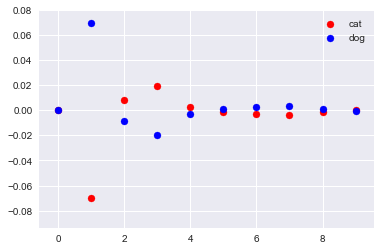

In [38]:
def plot_data(d=None, y=None):
    plt.figure()
    plt.scatter(np.arange(10), gauss_nbc.params[0,0].numpy(), c='r', label='cat')
    plt.scatter(np.arange(10), gauss_nbc.params[1,0].numpy(), c='b', label='dog')
    if d is not None and y is not None:
        plt.scatter(np.arange(10), d, c='g', label=y)
    plt.legend()
    plt.show()
    
plot_data()

Let's compute the training accuracy

In [37]:
num_correct = 0
N = 22500
labels = labels.long()
with torch.no_grad():
    for idx in tqdm(range(N)):
        x = data_reduced[idx]
        y = labels[idx]
        _, pred = torch.max(gauss_nbc(x), 0)
        if pred == y:
            num_correct += 1
print("Gaussian NBC training accuracy: {} %".format(num_correct / N))

HBox(children=(IntProgress(value=0, max=22500), HTML(value='')))


Gaussian NBC training accuracy: 0.5004 %


Simple Guassian NBC is not able to do much with this dataset! :( Not too surprising.
Just to see what happens, lets train LogReg on the full featurized dataset.

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(data, labels)

In [ ]:
training_accuracy = logreg.score(data, labels)
print('logreg training accuracy: {} %'.format(training_accuracy))

In [ ]:
print('logreg validation accuracy: {} %'.format(logreg.score(X, val_labels)))

## Titanic dataset

Let's try a simpler dataset so we can get some interesting results out of our Gaussian NBC